In [136]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import talib as ta  # Using TA-Lib instead of pandas_ta

# Set device for PyTorch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def download_stock_data(ticker, start_date, end_date):
    # Download stock data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def add_option_indicators(stock_data, ticker):
    # Get options data
    stock = yf.Ticker(ticker)
    try:
        opt = stock.option_chain('nearest')
        has_options = True
    except:
        has_options = False
    
    # Basic price momentum indicators
    df = stock_data.copy()
    
    # Weekly and Monthly Returns
    df['1w_return'] = df['Close'].pct_change(periods=5)
    df['2w_return'] = df['Close'].pct_change(periods=10)
    df['1m_return'] = df['Close'].pct_change(periods=21)
    
    # Volatility
    df['20d_vol'] = df['Close'].rolling(window=20).std()
    
    # Options-related indicators (if available)
    if has_options:
        df['call_oi'] = opt.calls['openInterest'].sum()
        df['put_call_ratio'] = opt.puts['openInterest'].sum() / opt.calls['openInterest'].sum()
        df['call_volume'] = opt.calls['volume'].sum()
    
    # Technical indicators using TA-Lib
    # Convert 'Close' to numpy array before passing to TA-Lib functions
    close_prices = df['Close'].to_numpy().flatten()  # Ensure it is 1D

    # Now pass it to TA-Lib functions
    df['RSI'] = ta.RSI(close_prices, timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    df['BBL'], df['BBM'], df['BBU'] = ta.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    # Momentum and Trend
    df['above_200ma'] = df['Close'] > df['Close'].rolling(window=200).mean()
    df['above_50ma'] = df['Close'] > df['Close'].rolling(window=50).mean()
    
    return df

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None  # Store best model state in memory
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if not torch.isnan(loss):  # Skip if loss is NaN
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += criterion(output, target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Save in memory
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)  # Load from memory
            break
            
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss = {avg_train_loss:.5f}, Val Loss = {avg_val_loss:.5f}')
    
    return train_losses, val_losses

def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        current_price = data[i, 3]  # Close price
        prev_price = data[i-1, 3]   # Previous close price
        if prev_price != 0:  # Prevent division by zero
            pct_change = (current_price - prev_price) / prev_price
            X.append(data[i-window_size:i, :])  # Only append window once
            y.append(pct_change)
    return np.array(X), np.array(y)

def predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data, num_days=7):
    model.eval()
    predictions = []
    last_window = features_scaled[-window_size:]
    last_price = stock_data['Close'].iloc[-1]
    last_features = enhanced_data.iloc[-1]  # Get the last row of features
    
    prediction_dates = pd.date_range(start=stock_data.index[-1] + timedelta(days=1), periods=num_days)
    
    with torch.no_grad():
        current_window = torch.FloatTensor(last_window).unsqueeze(0).to(device)
        current_price = last_price
        
        for i in range(num_days):
            # Predict percentage change
            pct_change = model(current_window).item()
            predicted_price = current_price * (1 + pct_change)
            predictions.append(predicted_price)
            
            # Update for next prediction
            current_price = predicted_price
            
            # Create new window by shifting
            new_window = current_window.clone()
            new_window[0, :-1, :] = new_window[0, 1:, :]
            
            # Update the last row with the new price
            new_features = last_features.copy()
            new_features['Close'] = predicted_price
            new_features['Open'] = predicted_price  # Simplification
            new_features['High'] = predicted_price  # Simplification
            new_features['Low'] = predicted_price   # Simplification
            
            # Scale the new features
            scaled_new_features = scaler.transform(new_features.values.reshape(1, -1))[0]
            new_window[0, -1, :] = torch.FloatTensor(scaled_new_features).to(device)
            current_window = new_window

    # Create DataFrame for predicted prices
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted Price': predictions,
        'Pct_Change': [(p/last_price - 1)*100 for p in predictions]
    })
    
    print("\nPredictions:")
    print(prediction_df)
    
    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-30:], stock_data['Close'][-30:], label='Historical')
    plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted', linestyle='--')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return prediction_df

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Deeper network
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_1 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.layer_norm(out)
        out = self.dropout(out)
        
        h0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0_2 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.layer_norm(out[:, -1, :])
        out = self.dropout(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()

Using device: mps


[*********************100%***********************]  1 of 1 completed

Training model for AAPL
Downloaded 751 days of data


Epoch 0: Train Loss = 1.53949, Val Loss = 0.02016
Epoch 5: Train Loss = 1.41981, Val Loss = 0.00419
Epoch 10: Train Loss = 1.42446, Val Loss = 0.00440
Early stopping at epoch 11

Predicting for AAPL

Predictions:
        Date                                    Predicted Price  \
0 2025-04-05  Ticker
AAPL    194.405035
Name: 2025-04-04 00:...   
1 2025-04-06  Ticker
AAPL    200.79166
Name: 2025-04-04 00:0...   
2 2025-04-07  Ticker
AAPL    207.676618
Name: 2025-04-04 00:...   
3 2025-04-08  Ticker
AAPL    215.009809
Name: 2025-04-04 00:...   
4 2025-04-09  Ticker
AAPL    222.76013
Name: 2025-04-04 00:0...   
5 2025-04-10  Ticker
AAPL    230.900423
Name: 2025-04-04 00:...   
6 2025-04-11  Ticker
AAPL    239.393003
Name: 2025-04-04 00:...   

                                          Pct_Change  
0  Ticker
AAPL    3.198339
Name: 2025-04-04 00:00...  
1  Ticker
AAPL    6.588626
Name: 2025-04-04 00:00...  
2  Ticker
AAPL    10.243451
Name: 2025-04-04 00:0...  
3  Ticker
AAPL    14.136216
Na

/Users/makeen/dev/StockModel/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/Users/makeen/dev/StockModel/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


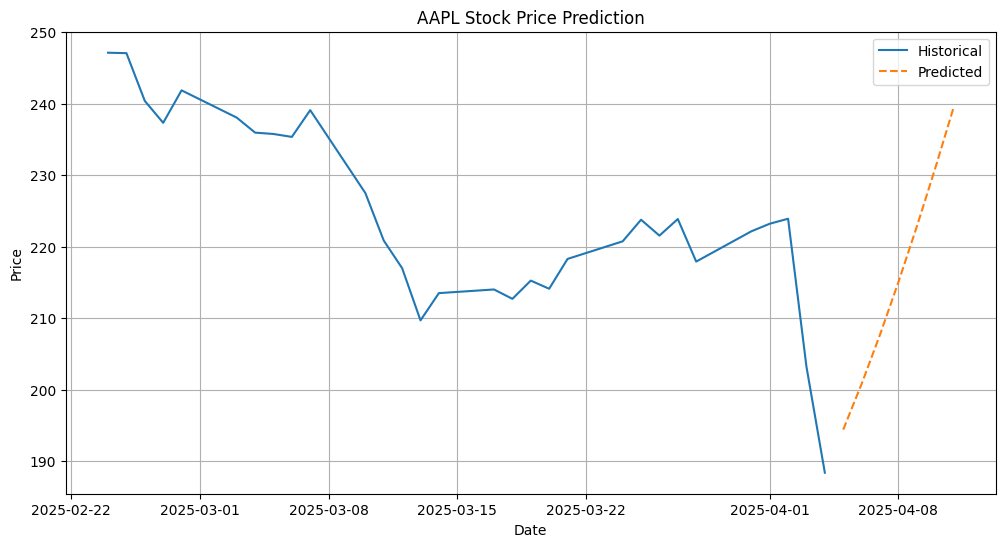

TypeError: unsupported format string passed to Series.__format__

In [137]:
def train(ticker):
    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*3)  # 3 years of data
    
    try:
        # Download and prepare data
        print(f"Downloading data for {ticker} from {start_date} to {end_date}")
        stock_data = download_stock_data(ticker, start_date, end_date)
        if stock_data.empty:
            raise ValueError(f"No data downloaded for {ticker}")
        
        print(f"Downloaded {len(stock_data)} days of data")
        
        # Handle missing values first
        stock_data = stock_data.ffill().bfill()
        enhanced_data = add_option_indicators(stock_data, ticker)
        
        # Define available features
        available_features = [
            'Open', 'High', 'Low', 'Close', 'Volume',  # OHLCV
            '1w_return', '2w_return', '1m_return', '20d_vol',  # Momentum
            'RSI', 'MACD', 'MACD_signal', 'MACD_hist',  # Technical
            'BBL', 'BBM', 'BBU',  # Bollinger Bands
            'above_200ma', 'above_50ma'  # Trend
        ]
        
        # Handle missing values
        enhanced_data = enhanced_data.ffill().bfill()
        enhanced_data = enhanced_data.dropna()
        
        if len(enhanced_data) == 0:
            raise ValueError("No valid data after preprocessing")
        
        # Select features and scale
        features = enhanced_data[available_features].values
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Create sliding windows
        window_size = 20
        X, y = create_sliding_windows(features_scaled, window_size)
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("No valid sequences created")
        
        # Split data
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Add validation set
        val_size = int(len(X_train) * 0.2)
        X_val = X_train[-val_size:]
        y_val = y_train[-val_size:]
        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]
        
        # Model parameters
        input_size = len(available_features)
        hidden_size = 128
        num_layers = 2
        output_size = 1
        
        # Initialize model
        model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        
        # Training parameters
        learning_rate = 0.0001
        num_epochs = 50
        batch_size = 32
        
        # Create data loaders
        train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), 
                                    torch.FloatTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.FloatTensor(X_val).to(device), 
                                  torch.FloatTensor(y_val).to(device))
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Optimizer with L2 regularization
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        # Train with validation
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        
        return model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data
        
    except Exception as e:
        print(f"Error in training: {str(e)}")
        return None, None, None, None, None, None, None

# Run the model
tickers = ["AAPL"]  # You can add more tickers here if you want
for ticker in tickers:
    print(f"Training model for {ticker}")
    result = train(ticker)
    if result[0] is not None:  # Check if training was successful
        model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data = result
        print(f"\nPredicting for {ticker}")
        predictions = predict(model, features_scaled, window_size, ticker, scaler, stock_data, enhanced_data)
        
        # Calculate accuracy metrics
        last_known_price = float(stock_data['Close'].iloc[-1])  # Convert to float
        first_prediction = float(predictions['Predicted Price'].iloc[0])  # Convert to float
        print(f"\nLast Known Price: ${last_known_price:.2f}")
        print(f"First Prediction: ${first_prediction:.2f}")
        print(f"Predicted Change: {((first_prediction/last_known_price - 1)*100):.2f}%")
    else:
        print(f"Skipping prediction for {ticker} due to training failure")